# **Bank Stock Price Forecasting 💹**
---
This dataset contains historical stock price data for major banks from the year 2014 to 2024. The dataset includes daily stock prices, trading volume, and other relevant financial metrics for prominent banks. The stock prices are provided in IDR (Indonesian Rupiah) currency.

# **Preparation Phase 🧺**
---
## **Install the Libraries 📚**
---

In [1]:
# Install the scalecast library at the begininng
!pip install scalecast --upgrade
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.6 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=8b2b894f51a29ac3df891b5feba77e9a0e9f86060dc971578a7cca1de0e0fdd2
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Un

## **Import the Libraries 🏪**
---

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-stock-price/Bank_Stock_Price_10Y.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt

## **Load the dataset 🗄️**
---

In [4]:
df = pd.read_csv('/kaggle/input/bank-stock-price/Bank_Stock_Price_10Y.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2483 non-null   object 
 1   Open       2483 non-null   float64
 2   High       2483 non-null   float64
 3   Low        2483 non-null   float64
 4   Close      2483 non-null   float64
 5   Adj Close  2483 non-null   float64
 6   Volume     2483 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 135.9+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-03,1980.0,2000.0,1965.0,1965.0,1691.382568,55407000
1,2014-02-04,1970.0,1980.0,1940.0,1970.0,1695.686035,83683500
2,2014-02-05,1980.0,1990.0,1965.0,1990.0,1712.901367,42715000
3,2014-02-06,1975.0,2030.0,1970.0,2030.0,1747.331299,63581000
4,2014-02-07,2050.0,2060.0,2035.0,2050.0,1764.546753,104825500


In [7]:
# Check for missing values
df.isna().sum()

# Locate NaN values in the 'Price' column
# nan_rows = df[df['Volume'].isna()]
# print(nan_rows)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df1 = df[['Date','Adj Close']].copy(deep=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1.rename(columns={'Adj Close': 'Price'}, inplace=True)
df1 = df1.resample('W').mean()
df1.ffill(inplace=True)

In [9]:
df1[:10].style.background_gradient(cmap='viridis')

,Price
Date,
2014-02-09 00:00:00,1722.369604
2014-02-16 00:00:00,1760.242798
2014-02-23 00:00:00,1789.508545
2014-03-02 00:00:00,1775.736426
2014-03-09 00:00:00,1806.723584
2014-03-16 00:00:00,1814.470337
2014-03-23 00:00:00,1831.685498
2014-03-30 00:00:00,1786.926196
2014-04-06 00:00:00,1878.596679


In [10]:
# Check for missing values
df1.isna().sum()

Price    0
dtype: int64

# **Exploratory Data Analysis 🔍**
---

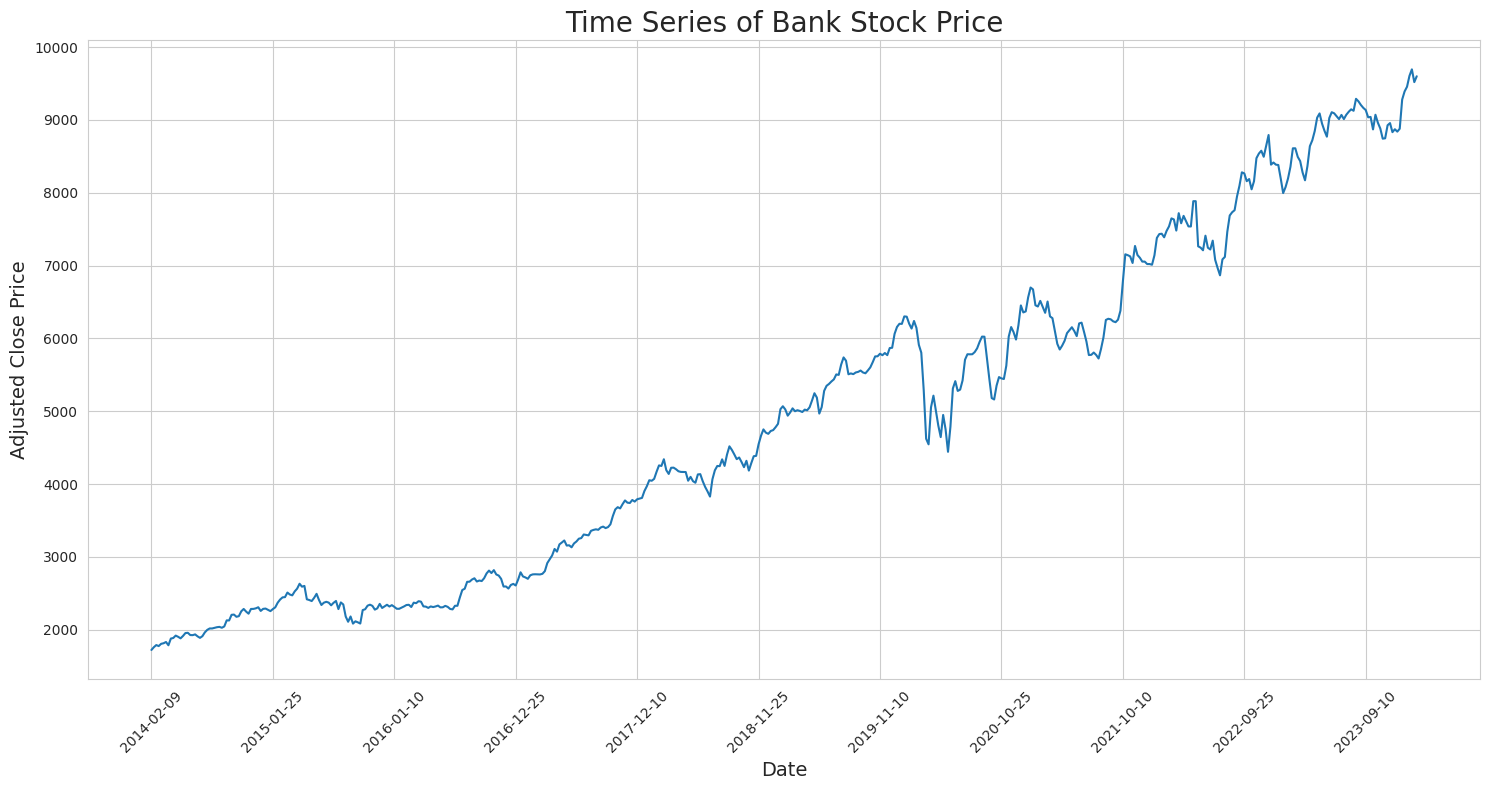

In [11]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
ax=sns.lineplot(data=df1, x=df1.index, y='Price')

# Set x-axis ticks for every 50th data point
n = 50  
plt.xticks(df1.index[::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.title("Time Series of Bank Stock Price", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Adjusted Close Price", fontsize=14)
plt.tight_layout()
plt.show()

# **Stationarity Test 🧪**
---

In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [13]:
def tsplot(y, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

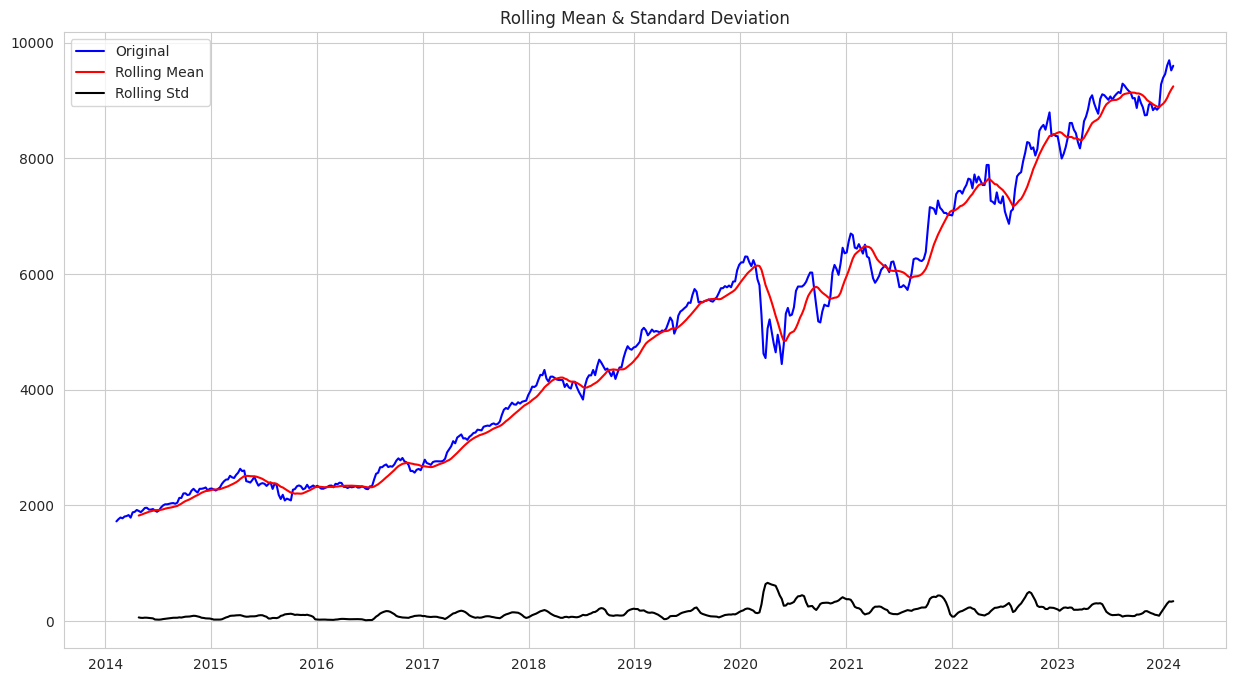

Results of Dickey-Fuller Test:
Test Statistic                   1.025763
p-value                          0.994530
#Lags Used                      17.000000
Number of Observations Used    504.000000
Critical Value (1%)             -3.443392
Critical Value (5%)             -2.867292
Critical Value (10%)            -2.569833
dtype: float64


In [14]:
test_stationarity(df1['Price'])

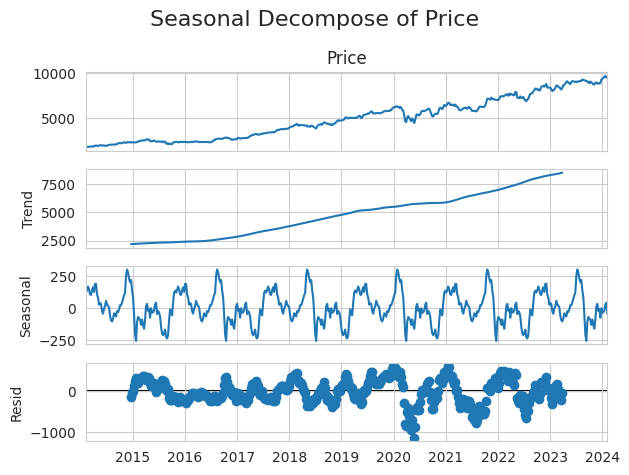

In [15]:
dec = sm.tsa.seasonal_decompose(df1['Price'], period=90).plot()

plt.suptitle('Seasonal Decompose of Price', fontsize=16)
plt.tight_layout()
plt.show()

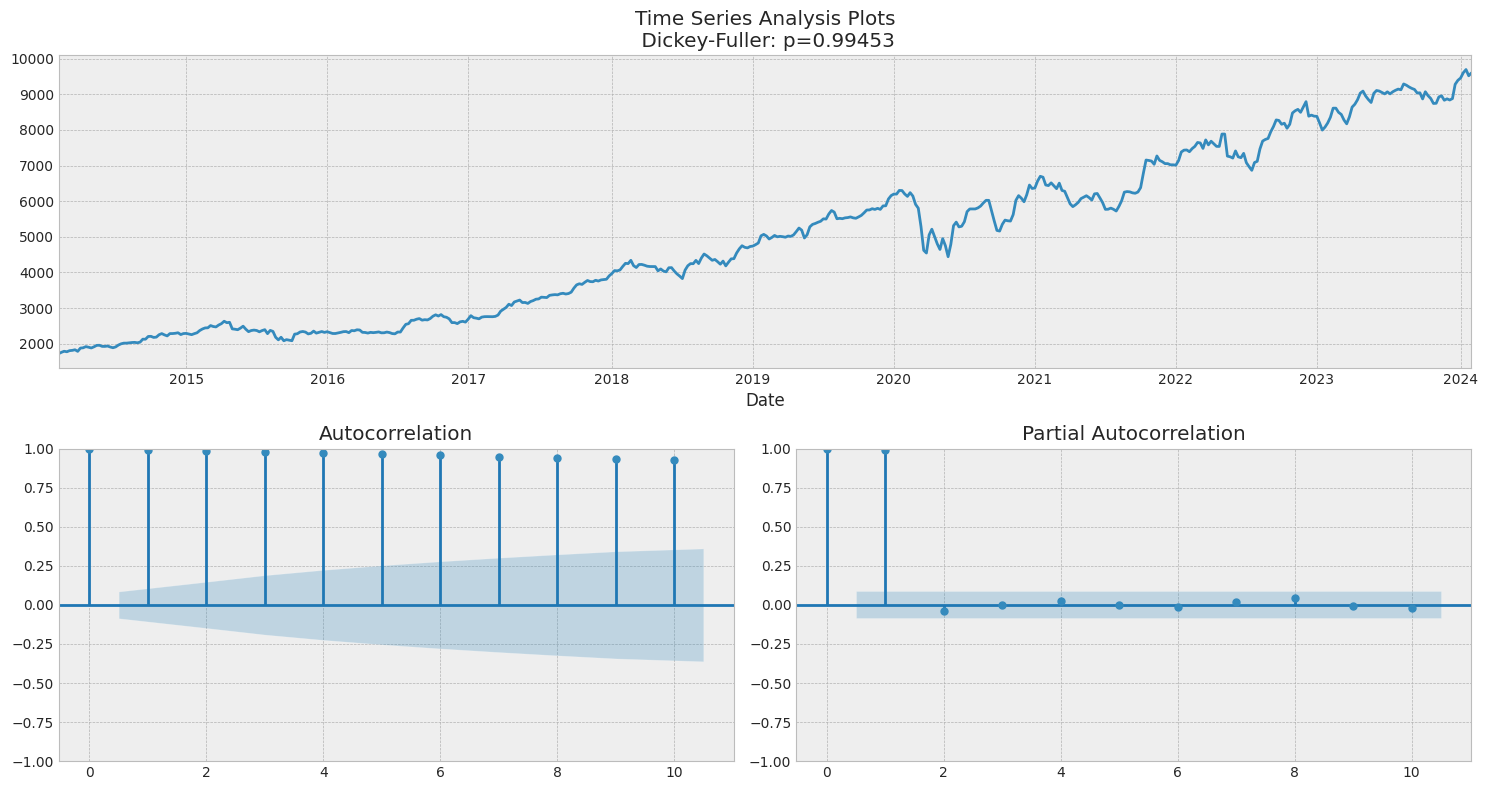

In [16]:
tsplot(df1['Price'],lags = 10)

# **Build the Model 🤖**
---

In [17]:
f = Forecaster(y=df1.Price,current_dates=df1.index)

f.set_test_length(0.3) # 30% test set
f.generate_future_dates(90)

f.set_estimator('lstm')
f.eval_cis(mode=True, cilevel=0.95)

In [18]:
f.manual_forecast(call_me='lstm_7lags_5epochs',
                  lags=24,
                  epochs=5,
                  validation_split=.2,
                  shuffle=True)

2024-02-09 18:08:11.092044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 18:08:11.092201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 18:08:11.289313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/5
5/5 [==============================] - 4s 255ms/step - loss: 0.3391 - val_loss: 0.6290
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.3320 - val_loss: 0.6193
Epoch 3/5
5/5 [==============================] - 0s 23ms/step - loss: 0.3242 - val_loss: 0.6083
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.3155 - val_loss: 0.5956
Epoch 5/5
1/1 [==============================] - 1s 507ms/step
Epoch 1/5
11/11 [==============================] - 3s 69ms/step - loss: 0.3085 - val_loss: 0.7063
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.2889 - val_loss: 0.6748
Epoch 3/5
11/11 [==============================] - 0s 16ms/step - loss: 0.2619 - val_loss: 0.6280
Epoch 4/5
11/11 [==============================] - 0s 14ms/step - loss: 0.2274 - val_loss: 0.5593
Epoch 5/5
13/13 [==============================] - 0s 4ms/step


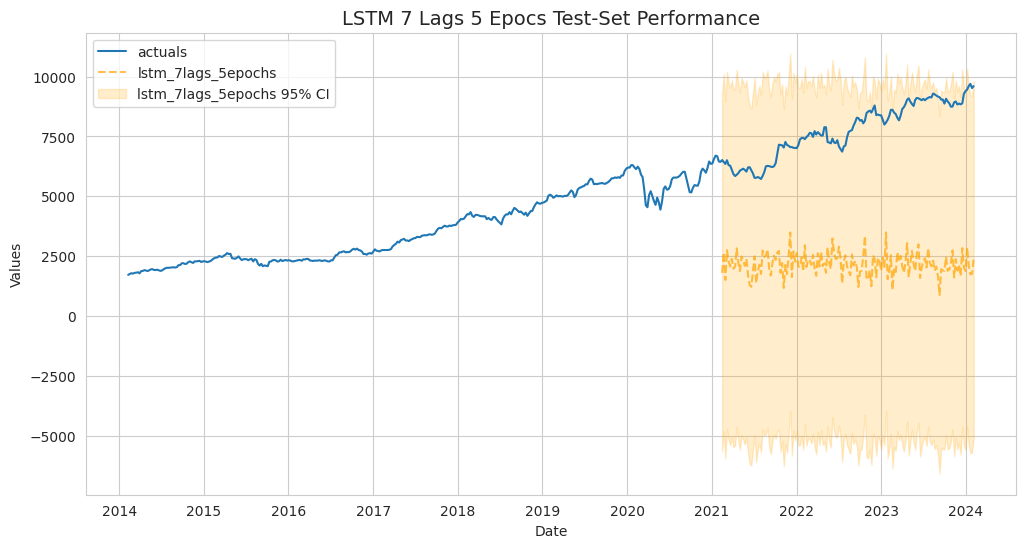

In [19]:
f.plot_test_set(models='lstm_7lags_5epochs',ci=True)
plt.title('LSTM 7 Lags 5 Epocs Test-Set Performance',size=14)
plt.show()

In [20]:
f.set_estimator('mlr') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month','quarter',dummy=True) 
f.add_seasonal_regressors('year') 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

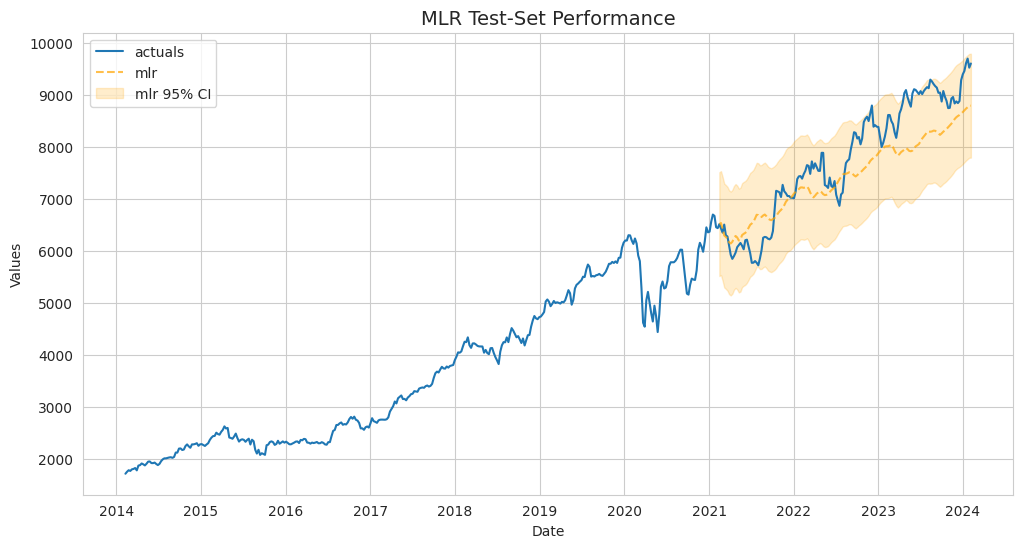

In [21]:
f.manual_forecast(call_me='mlr')
f.plot_test_set(models='mlr', ci=True)
plt.title('MLR Test-Set Performance',size=14)
plt.show()

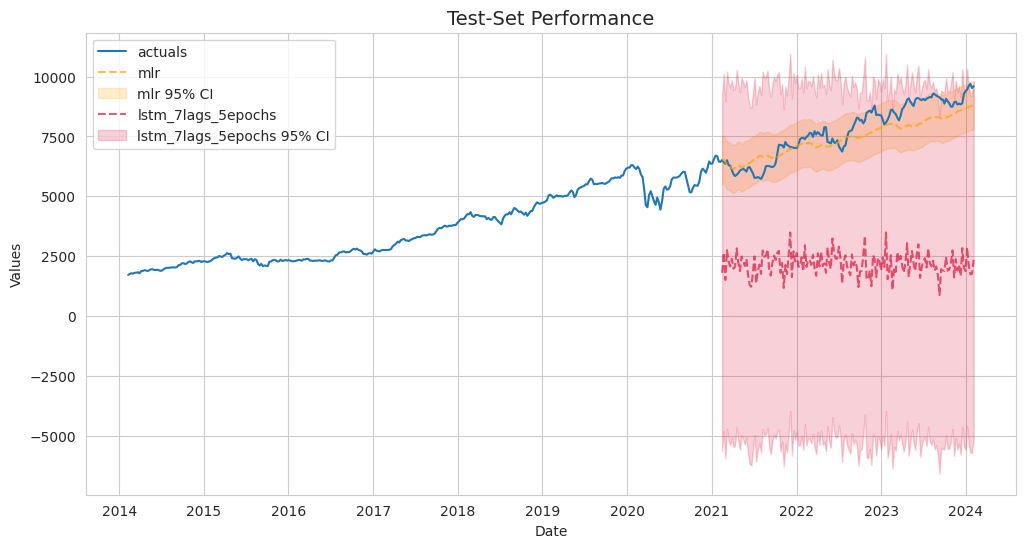

In [22]:
f.manual_forecast()
f.plot_test_set(ci=True, order_by='TestSetRMSE',models='top_2')
plt.title('Test-Set Performance',size=14)
plt.show()

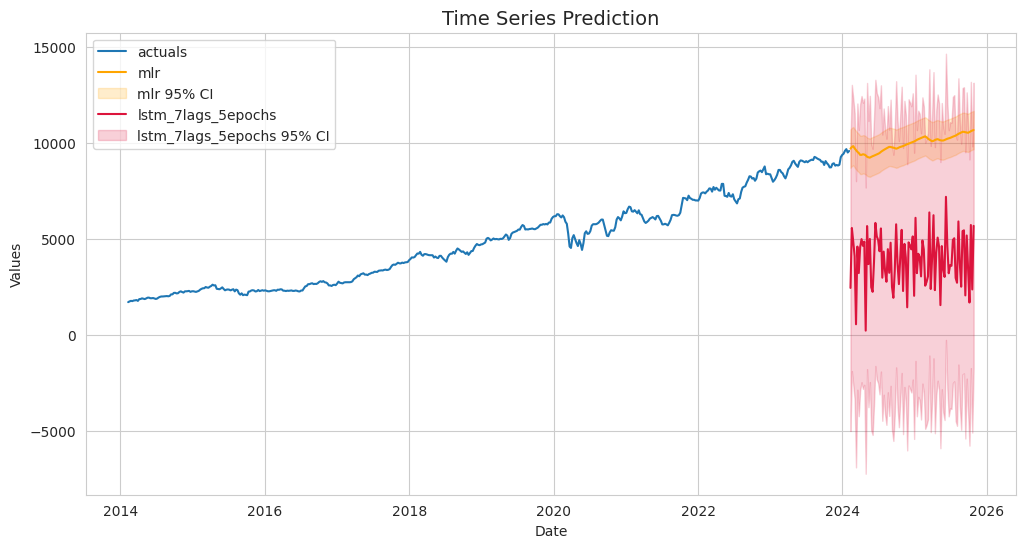

In [23]:
f.plot(models=['mlr','lstm_7lags_5epochs'],
       order_by='TestSetR2',
       ci=True)
plt.title('Time Series Prediction',size=14)
plt.show()

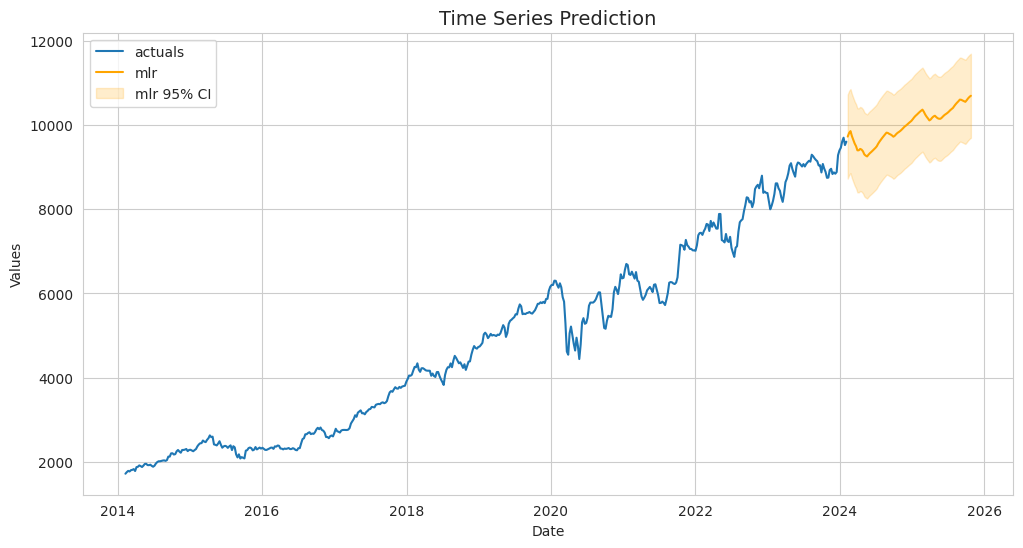

In [24]:
f.plot(models=['mlr'], order_by='TestSetR2', ci=True)
plt.title('Time Series Prediction',size=14)
plt.show()

# **Model Evaluation 📝**
---

In [25]:
model_summary = f.export('model_summaries', determine_best_by='TestSetRMSE')[
                         ['ModelNickname',
                          'TestSetMAPE',
                          'TestSetRMSE',
                          'TestSetR2',
                          'best_model']]

model_summary.head(10)

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,mlr,0.062641,589.725298,0.724799,True
1,lstm_7lags_5epochs,0.712943,5721.250001,-24.901968,False


In [26]:
model_summary['rank'] = model_summary['TestSetRMSE'].rank(ascending=True)
model_summary

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model,rank
0,mlr,0.062641,589.725298,0.724799,True,1.0
1,lstm_7lags_5epochs,0.712943,5721.250001,-24.901968,False,2.0


# **References**
---
* [Bank Stock Price](https://www.kaggle.com/datasets/brmil07/bank-stock-price)
* [Time Series Forecasting](https://www.kaggle.com/code/brmil07/time-series-forecasting)